In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mesaPlot as mp
import pandas as pd
from custom_mpl_settings import load_mpl_rc
load_mpl_rc()
cmap = plt.get_cmap('viridis')
m = mp.MESA()
from functions import add_Teff

from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.MS_table_builder import MainSequenceTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.GB_table_builder import RedGiantBranchTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.CHeB_table_builder import (
    CoreHeliumBurningTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.EAGB_table_builder import (
    EarlyAsymptoticGiantBranchTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.config.table_columns import table_columns

evol_phase = 'CHeB'

settings = {
    **table_columns,
    'grid_directory':f'/Users/natalierees/MINT_grids_23051/Z0.02/CHeB',
    'metallicity':0.02,
    'num_processes':4
}
tester = CoreHeliumBurningTableBuilder(settings=settings)


/Users/natalierees/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

In [9]:
evol_phase = 'CHeB'
metallicity = 0.02
table_name = "tracks_Z%7.2e_%s.csv" %(float(metallicity),evol_phase)
table_filepath = os.path.join(f'/Users/natalierees/MINT_grids_23051/Z{metallicity}/{evol_phase}',table_name)
df = pd.read_csv(table_filepath,index_col=[0])
df.reset_index(inplace=True,drop=True)
df = add_Teff(df)
df['HELIUM_LUMINOSITY_DIV_LUMINOSITY'] = df['HELIUM_LUMINOSITY']/df['LUMINOSITY']
df['HELIUM_CORE_MASS'] = df['HELIUM_CORE_MASS_FRACTION']*df["MASS"]
df_sse = df[df['INITIAL_MASS']==df['MASS']]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65194 entries, 0 to 65193
Data columns (total 56 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   MASS                                         65194 non-null  float64
 1   CENTRAL_HELIUM                               65194 non-null  float64
 2   HELIUM_CORE_MASS_FRACTION                    65194 non-null  float64
 3   RADIUS                                       65194 non-null  float64
 4   LUMINOSITY                                   65194 non-null  float64
 5   LUMINOSITY_DIV_EDDINGTON_LUMINOSITY          65194 non-null  float64
 6   NEUTRINO_LUMINOSITY                          65194 non-null  float64
 7   HELIUM_LUMINOSITY                            65194 non-null  float64
 8   AGE                                          65194 non-null  float64
 9   CENTRAL_DEGENERACY                           65194 non-null  float64
 10

In [19]:
M=1.0
tester.integrate_CME(mass=M)
fig,ax=plt.subplots()
ax = tester.plot_HR_SSE(tester.df_MESA_dict, tester.df_evol_dict, ax, M)
plt.show()

Starting MS: MASS: 1.0, CENTRAL_HYDROGEN: 0.6985
Finished MS: MASS: nan, CENTRAL_HYDROGEN: nan


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

# mass_list = [1.0,2.0,4.0,8.0,16.0]
mass_list = [1.0]

for M in mass_list[:]:
    tester.integrate_CME(mass=M)
    df_int = tester.df_evol_dict['GB']
    x = df_int['LOG_EFFECTIVE_TEMPERATURE'].values
    y = df_int['LOG_LUMINOSITY'].values

    if M != mass_list[-1]:
        ax.plot(x,y,ls='-',c='black')
        ax.annotate(str(M)+r'$~\mathrm{M}_\odot$', xy=(x[0], y[0]), textcoords = 'offset points', xytext=(-100, 0),
                arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 10),size=15)
    else:
        ax.plot((df_int['LOG_EFFECTIVE_TEMPERATURE']),(df_int['LOG_LUMINOSITY']),ls='-',c='black',label='MINT')
        ax.annotate(str(M)+r'$~\mathrm{M}_\odot$', xy=(x[-1], y[-1]), textcoords = 'offset points', xytext=(30, 0),
                arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 10),size=15)

ax.invert_xaxis()
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlim(xlim[0]+0.1,xlim[1])
plt.ylim(ylim)

df_HR = df_sse[(df_sse['MASS']>mass_list[0]*0.8)&(df_sse['MASS']<mass_list[-1]*1.2)]
ax.scatter(np.log10(df_HR['EFFECTIVE_TEMPERATURE']),np.log10(df_HR['LUMINOSITY']),c=np.log10(df_HR['MASS']),alpha=1.0,s=1,label='MESA')


ax.set(ylabel='$\log (L~/\mathrm{L}_\odot)$')
ax.set(xlabel='$\log (T_\mathrm{eff}~/\mathrm{K})$')
ax.legend()


plt.savefig(f'plots/Z{metallicity}_{evol_phase}_MINT_HR.jpeg',dpi=200)


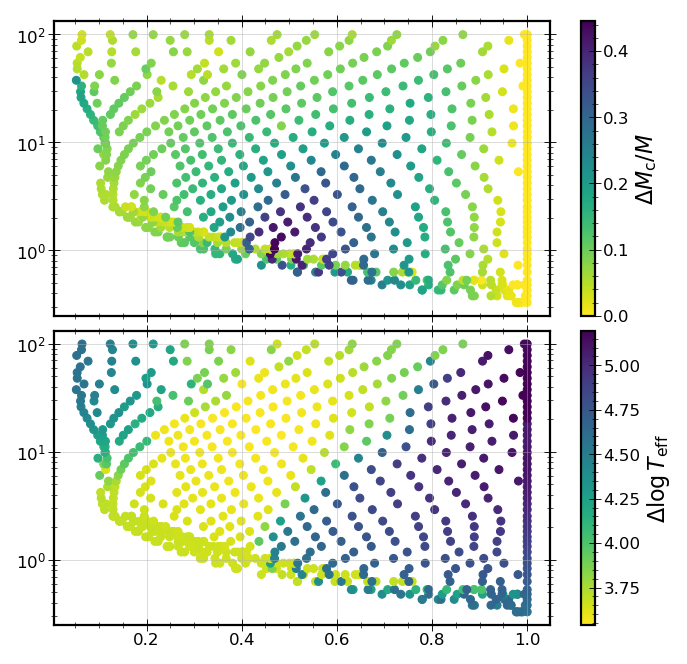

In [40]:
df['LOG_EFFECTIVE_TEMPERATURE'] = np.log10(df['EFFECTIVE_TEMPERATURE'])
Mc = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS_FRACTION'].min().values
delta_logTeff = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['LOG_EFFECTIVE_TEMPERATURE'].max()-x['LOG_EFFECTIVE_TEMPERATURE'].values[0]).values
max_logTeff = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['LOG_EFFECTIVE_TEMPERATURE'].max()).values
mass = df.groupby(['MASS','INITIAL_MASS'])['MASS'].min().values
delta_Mc = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['HELIUM_CORE_MASS_FRACTION'].max()-x['HELIUM_CORE_MASS_FRACTION'].min()).values

fig,ax=plt.subplots(2,1,figsize=(10,10),sharey=True,sharex=True)  

sc = ax[0].scatter(Mc,(mass),c=delta_Mc,cmap=cmap.reversed(),s=50)
cbar = plt.colorbar(sc,ax=ax[0],location='right',label=r'$\Delta M_\mathrm{c}/M$')

sc = ax[1].scatter(Mc,(mass),c=max_logTeff,cmap=cmap.reversed(),s=50)
cbar = plt.colorbar(sc,ax=ax[1],location='right',label=r'$\Delta \log T_\mathrm{eff}$')
ax[1].set_yscale('log')

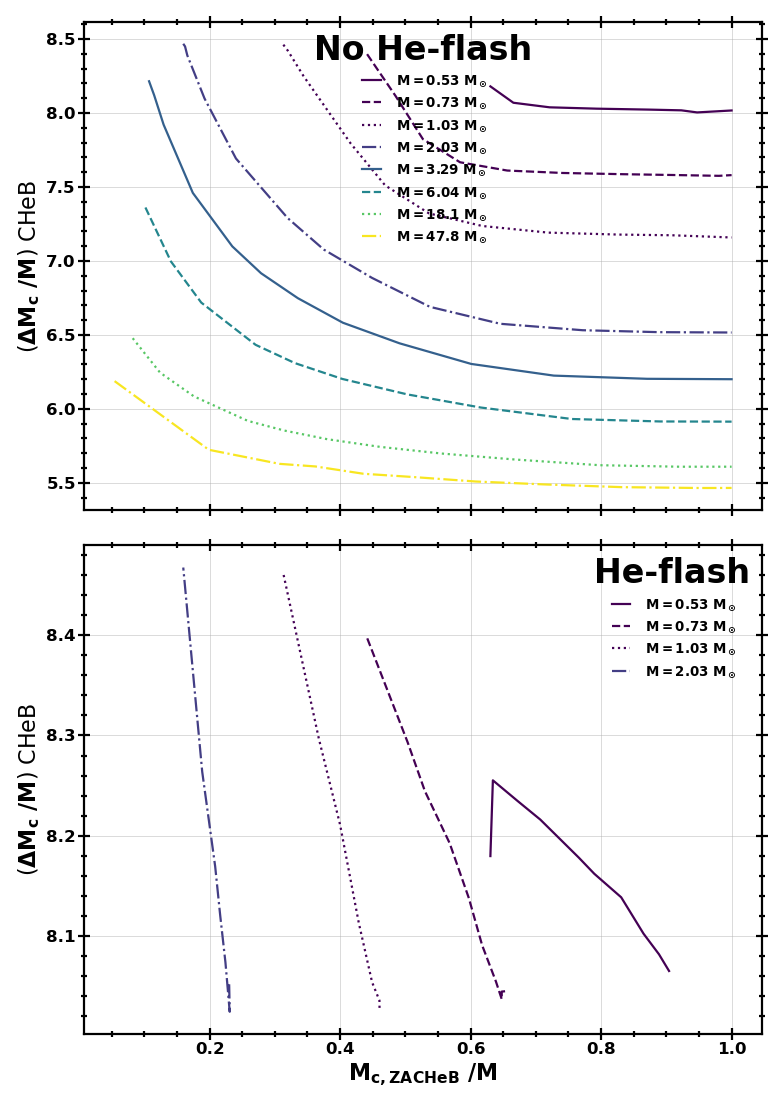

In [4]:

df_he_flash, df_no_he_flash = tester.split_tracks_post_he_ignition(df=df)
fig,ax = plt.subplots(2,1,figsize=(10,14),sharex=True,sharey=False)
mass_list = [0.53,0.73,1.03,2.03,3.29,6.04,18.1,47.8]
# mass_list = [1.03]
markers = ['s','x']
for i, dfx in enumerate([df_no_he_flash, df_he_flash]):
    for M in [M for M in mass_list if M in dfx['MASS'].unique()]:
        df_mass = dfx[dfx['MASS']==M]
        tau = df_mass.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['AGE'].max()-x['AGE'].min()).values
        ZACHeB_Mc = df_mass.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['HELIUM_CORE_MASS_FRACTION'].min()).values
        ax[i].plot(ZACHeB_Mc,np.log10(tau),c =cmap(np.log10(M)/np.log10(50)),label='$M={}$'.format(M)+'$~\mathrm{M}_\odot$')#marker = markers[i],markersize=10)

ax[1].set(xlabel='$M_\mathrm{c,ZACHeB}~/M$')
ax[0].set(ylabel=r'($\Delta M_\mathrm{c}~/M$) CHeB')
ax[0].legend(title = 'No He-flash',frameon=False,fontsize=12)
ax[1].legend(title = 'He-flash',frameon=False,fontsize=12)
ax[1].set(ylabel=r'($\Delta M_\mathrm{c}~/M$) CHeB')

# ax[0].set_ylim(0,0.55)
fig.tight_layout()

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_lifetime.jpeg',dpi=200)
plt.show()

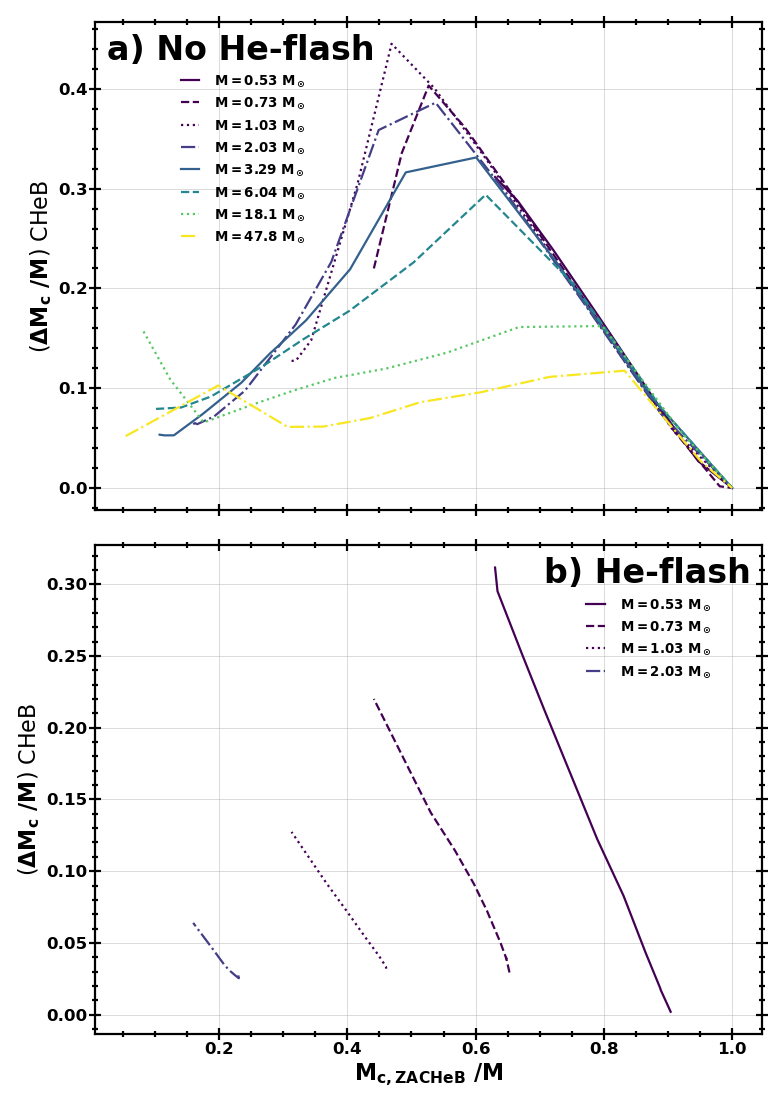

In [7]:

df_he_flash, df_no_he_flash = tester.split_tracks_post_he_ignition(df=df)
fig,ax = plt.subplots(2,1,figsize=(10,14),sharex=True,sharey=False)
mass_list = [0.53,0.73,1.03,2.03,3.29,6.04,18.1,47.8]
markers = ['s','x']
for i, dfx in enumerate([df_no_he_flash, df_he_flash]):
    for M in [M for M in mass_list if M in dfx['MASS'].unique()]:
        df_mass = dfx[dfx['MASS']==M]
        delta_Mc = df_mass.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['HELIUM_CORE_MASS_FRACTION'].max()-x['HELIUM_CORE_MASS_FRACTION'].min()).values
        ZACHeB_Mc = df_mass.groupby(['MASS','INITIAL_MASS']).apply(lambda x: x['HELIUM_CORE_MASS_FRACTION'].min()).values
        ax[i].plot(ZACHeB_Mc,delta_Mc,c =cmap(np.log10(M)/np.log10(50)),label='$M={}$'.format(M)+'$~\mathrm{M}_\odot$')#marker = markers[i],markersize=10)

ax[1].set(xlabel='$M_\mathrm{c,ZACHeB}~/M$')
ax[0].set(ylabel=r'($\Delta M_\mathrm{c}~/M$) CHeB')
ax[0].legend(title = 'a) No He-flash',frameon=False,fontsize=12)
ax[1].legend(title = 'b) He-flash',frameon=False,fontsize=12)
ax[1].set(ylabel=r'($\Delta M_\mathrm{c}~/M$) CHeB')

# ax[0].set_ylim(0,0.55)
fig.tight_layout()

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_core_mass_growth.jpeg',dpi=200)
plt.show()


No handles with labels found to put in legend.


No handles with labels found to put in legend.


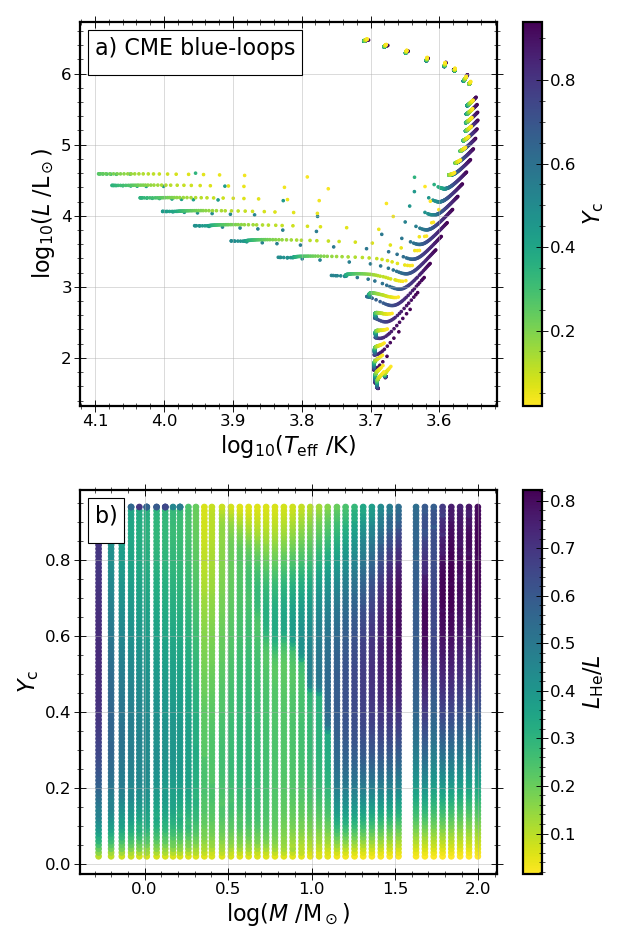

In [21]:
fig,ax=plt.subplots(2,1,figsize = (8,12))

df_he_burn = df_sse[(df_sse['CENTRAL_HELIUM']>0.01) & (df_sse['CENTRAL_HELIUM']<0.95)]
sc = ax[1].scatter(np.log10(df_he_burn['MASS']),df_he_burn['CENTRAL_HELIUM'],c=df_he_burn['HELIUM_LUMINOSITY_DIV_LUMINOSITY'],cmap=cmap.reversed())
cbar = plt.colorbar(sc,ax=ax[1],location='right',label='$L_\mathrm{He}/L$')
ax[1].set(xlabel='$\log(M~/\mathrm{M}_\odot)$',ylabel='$Y_\mathrm{c}$')
ax[1].legend(title='b)')

df_he_burn = df_sse[(df_sse['CENTRAL_HELIUM']>0.01) & (df_sse['CENTRAL_HELIUM']<0.95)&(df_sse['MASS']>2.0)]
df_he_burn=df_he_burn.sort_values(['CENTRAL_HELIUM'],ascending=False)
sc = ax[0].scatter(np.log10(df_he_burn['EFFECTIVE_TEMPERATURE']),np.log10(df_he_burn['LUMINOSITY']),c=df_he_burn['CENTRAL_HELIUM'],s=5,cmap=cmap.reversed())
ax[0].invert_xaxis()
ax[0].set(xlabel='$\log_{10} (T_\mathrm{eff}~/\mathrm{K})$',ylabel='$\log_{10} (L~/\mathrm{L}_\odot)$')
cbar = plt.colorbar(sc,ax=ax[0],location='right',label='$Y_\mathrm{c}$')#label='$L_\mathrm{He}/L$')
ax[0].legend(title='a) CME blue-loops',frameon=True)

fig.tight_layout()

plt.savefig(f'plots/Z{metallicity}_{evol_phase}_CME_blue_loops.jpeg',dpi=200)
plt.show()

No handles with labels found to put in legend.


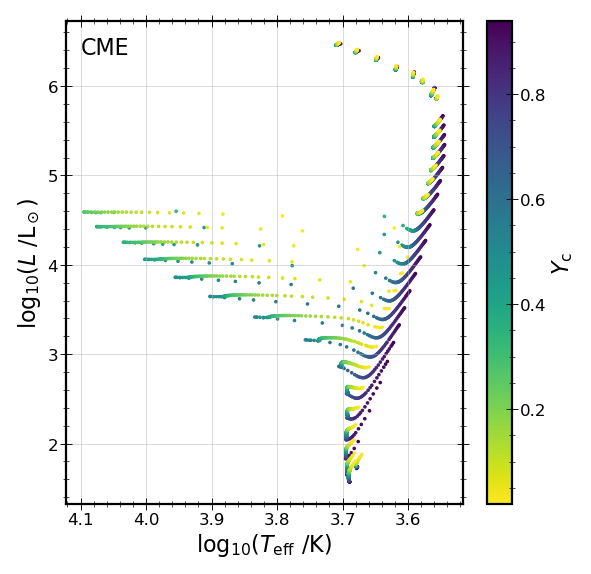

In [11]:
df_he_burn = df_sse[(df_sse['CENTRAL_HELIUM']>0.01) & (df_sse['CENTRAL_HELIUM']<0.95)&(df_sse['MASS']>2.0)]
df_he_burn=df_he_burn.sort_values(['CENTRAL_HELIUM'],ascending=False)
fig,ax=plt.subplots(figsize=(8,8))
sc = ax.scatter(np.log10(df_he_burn['EFFECTIVE_TEMPERATURE']),np.log10(df_he_burn['LUMINOSITY']),c=df_he_burn['CENTRAL_HELIUM'],s=5,cmap=cmap.reversed())
ax.invert_xaxis()
ax.set(xlabel='$\log_{10} (T_\mathrm{eff}~/\mathrm{K})$',ylabel='$\log_{10} (L~/\mathrm{L}_\odot)$')
cbar = plt.colorbar(sc,ax=ax,location='right',label='$Y_\mathrm{c}$')#label='$L_\mathrm{He}/L$')
ax.legend(title='CME',frameon=False)
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_SSE_blue_loops.jpeg',dpi=200)
plt.show()

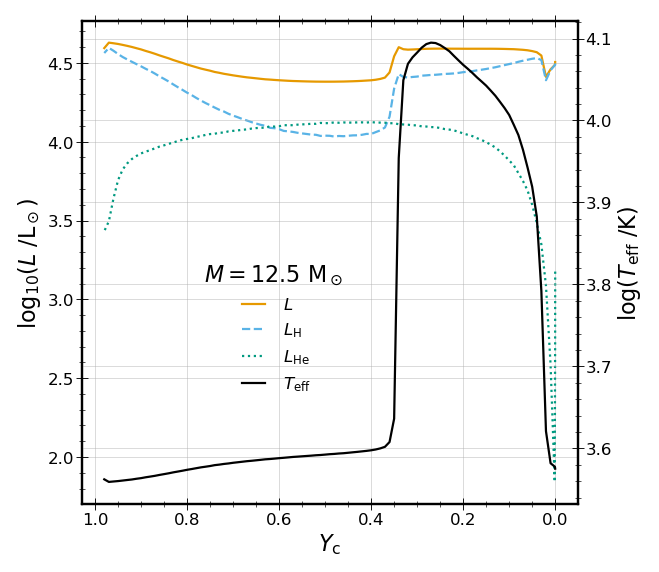

In [128]:
M = 12.5
fig,ax=plt.subplots(figsize=(8,8))
ax2 = ax.twinx()
df_mass = df[(df['MASS']==M)&(df['INITIAL_MASS']==M)]
ax.plot(df_mass['CENTRAL_HELIUM'],np.log10(df_mass['LUMINOSITY']),label='$L$')
ax.plot(df_mass['CENTRAL_HELIUM'],np.log10(df_mass['LUMINOSITY']-df_mass['HELIUM_LUMINOSITY']),label='$L_\mathrm{H}$')
ax.plot(df_mass['CENTRAL_HELIUM'],np.log10(df_mass['HELIUM_LUMINOSITY']),label='$L_\mathrm{He}$')
ax2.plot(df_mass['CENTRAL_HELIUM'],np.log10(df_mass['EFFECTIVE_TEMPERATURE']),label='$T_\mathrm{eff}$',color='black')
fig.legend(title = '$M=12.5~\mathrm{M}_\odot$',frameon=False,loc=(0.3,0.3))
ax.set(xlabel='$Y_\mathrm{c}$',ylabel='$\log_{10}(L~/\mathrm{L}_\odot)$')
ax2.set(ylabel='$\log(T_\mathrm{eff}~/\mathrm{K})$')
ax.invert_xaxis()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_12.5_blue_loop_driving.jpeg',dpi=200)
plt.show()

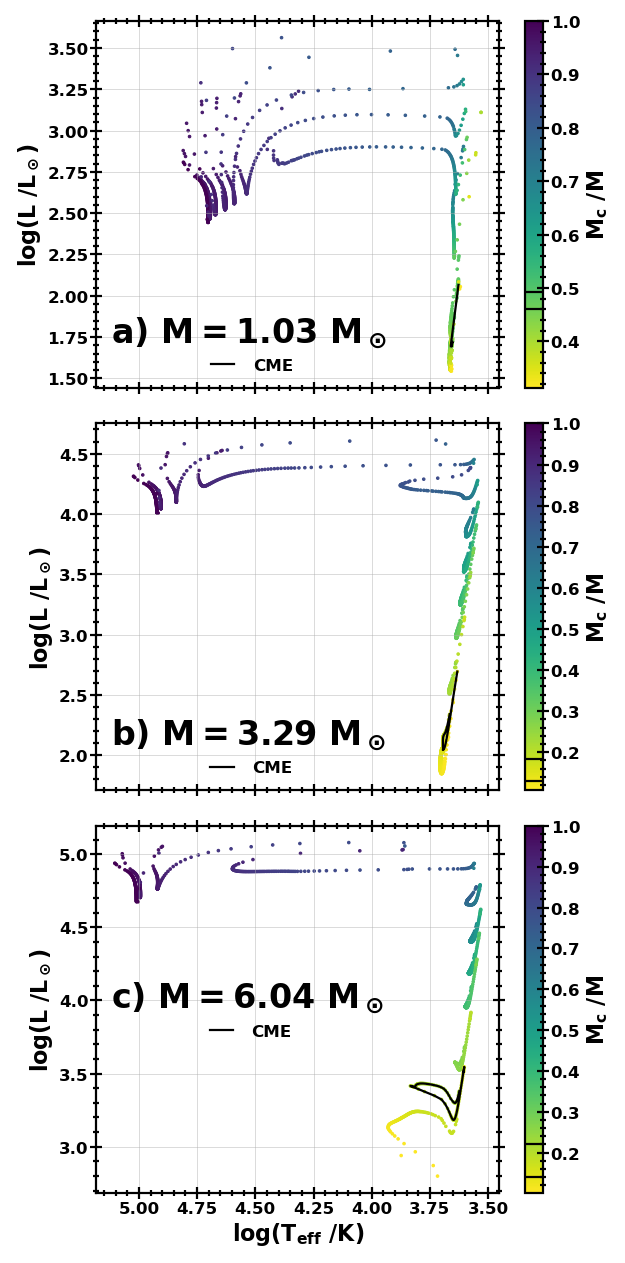

In [129]:

masses = [1.03,3.29,6.04]
fig,ax=plt.subplots(3,1,figsize=(8,16),sharex=True,sharey=False)
axs = ax.flatten()
labels = ['a','b','c']

for i, mass in enumerate(masses):
    
    df_mass = df[df['MASS']==mass]
    sc = axs[i].scatter(np.log10(df_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_mass['LUMINOSITY']),c=df_mass['HELIUM_CORE_MASS_FRACTION'],s=5,cmap=cmap.reversed())

    df_sse_mass = df_sse[df_sse['MASS']==mass]
    axs[i].plot(np.log10(df_sse_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_sse_mass['LUMINOSITY']),c='black',ls='-',label='CME')

    axs[i].legend(title=f'{labels[i]}) $M={mass}$'+'$~\mathrm{M}_\odot$',frameon=False)

    cbar = plt.colorbar(sc,ax=axs[i],location='right',label='$M_\mathrm{c}~/M$')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].min(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].max(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')

axs[0].invert_xaxis()

# ax[1].yaxis.set_ticks_position("right")
ax[2].set(xlabel='$\log (T_\mathrm{eff}~/\mathrm{K})$',ylabel='$\log (L~/\mathrm{L}_\odot)$')
ax[0].set(ylabel='$\log (L~/\mathrm{L}_\odot)$')
ax[1].set(ylabel='$\log (L~/\mathrm{L}_\odot)$')

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_HR.jpeg',dpi=200)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


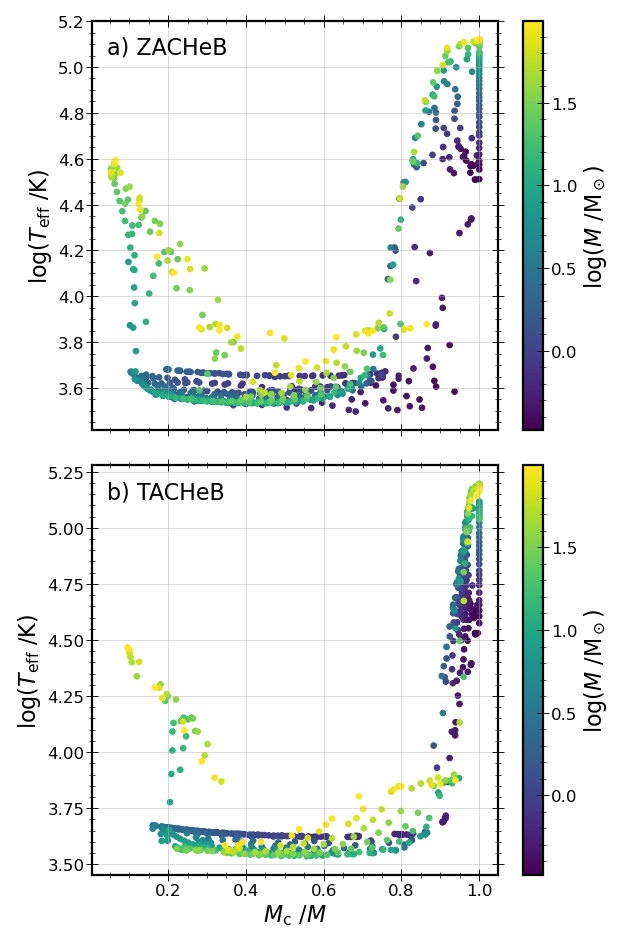

In [94]:
# STRIPPED STARS

ZACHeB_Teff = np.log10(df.groupby(['MASS','INITIAL_MASS'])['EFFECTIVE_TEMPERATURE'].last())
ZACHeB_Mc_frac = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS_FRACTION'].last()
TACHeB_Teff = np.log10(df.groupby(['MASS','INITIAL_MASS'])['EFFECTIVE_TEMPERATURE'].first())
TACHeB_Mc_frac = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS_FRACTION'].first()
M = df.groupby(['MASS','INITIAL_MASS'])['MASS'].last()

fig,ax=plt.subplots(2,1,figsize=(8,12),sharex=True)
sc = ax[0].scatter(ZACHeB_Mc_frac,ZACHeB_Teff,c=np.log10(M))
cbar = plt.colorbar(sc,ax=ax[0],location='right',label='$\log(M~/\mathrm{M}_\odot)$')
sc = ax[1].scatter(TACHeB_Mc_frac,TACHeB_Teff,c=np.log10(M))
cbar = plt.colorbar(sc,ax=ax[1],location='right',label='$\log(M~/\mathrm{M}_\odot)$')
# ax.vlines(0.9,TACHeB_Teff.min(),TACHeB_Teff.max())
ax[1].set(xlabel='$M_\mathrm{c}~/M$')
ax[0].set(ylabel='$\log(T_\mathrm{eff}~/\mathrm{K})$')
ax[1].set(ylabel='$\log(T_\mathrm{eff}~/\mathrm{K})$')

ax[0].legend(title='a) ZACHeB',frameon=False)
ax[1].legend(title='b) TACHeB',frameon=False)

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_Teff_ZACHeB_TACHeB.jpeg',dpi=200)
plt.show()

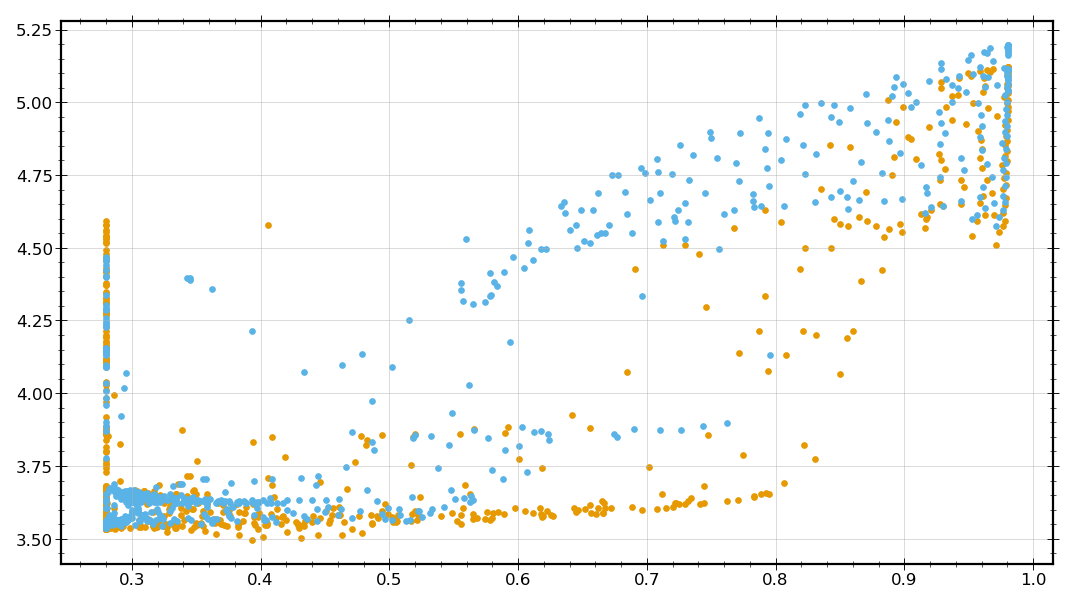

In [92]:
df['SURFACE_HELIUM_MASS_FRACTION'] = df['CHEBYSHEV_HELIUM_MASS_FRACTION'].apply(lambda x:float(x.split()[-2]))

df_ZACHeB = df[df['CENTRAL_HELIUM'] == df['CENTRAL_HELIUM'].unique()[-1]]
df_TACHeB = df[df['CENTRAL_HELIUM'] == df['CENTRAL_HELIUM'].unique()[0]]

plt.scatter(df_ZACHeB['SURFACE_HELIUM_MASS_FRACTION'],np.log10(df_ZACHeB['EFFECTIVE_TEMPERATURE']))
plt.scatter(df_TACHeB['SURFACE_HELIUM_MASS_FRACTION'],np.log10(df_TACHeB['EFFECTIVE_TEMPERATURE']))

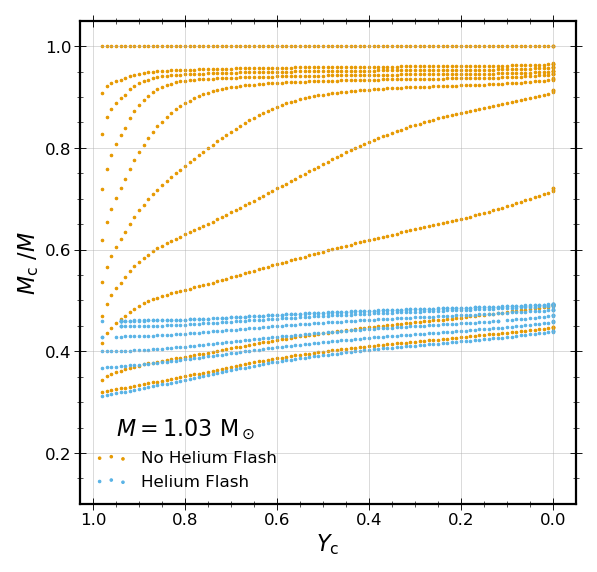

In [8]:
fig,ax=plt.subplots(1,1,figsize=(8,8),sharex=True,sharey=True)
mass = 1.03
    
df_mass = df[df['MASS']==mass]

df_no_flash = df_mass[df_mass['INITIAL_MASS']>2.5]
df_flash = df_mass[df_mass['INITIAL_MASS']<2.5]

ax.scatter(df_no_flash['CENTRAL_HELIUM'],df_no_flash['HELIUM_CORE_MASS_FRACTION'],label='No Helium Flash',s=5)
ax.scatter(df_flash['CENTRAL_HELIUM'],df_flash['HELIUM_CORE_MASS_FRACTION'],label='Helium Flash',s=5)

ax.legend(title=f'$M={mass}$'+'$~\mathrm{M}_\odot$',frameon=False)

ax.set(xlabel='$Y_\mathrm{c}$',ylabel='$M_\mathrm{c}~/M$')
ax.set(xlabel='$Y_\mathrm{c}$')
ax.set_ylim(0.1,1.05)
ax.invert_xaxis()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_tracks.jpeg',dpi=200)
plt.show()

No handles with labels found to put in legend.


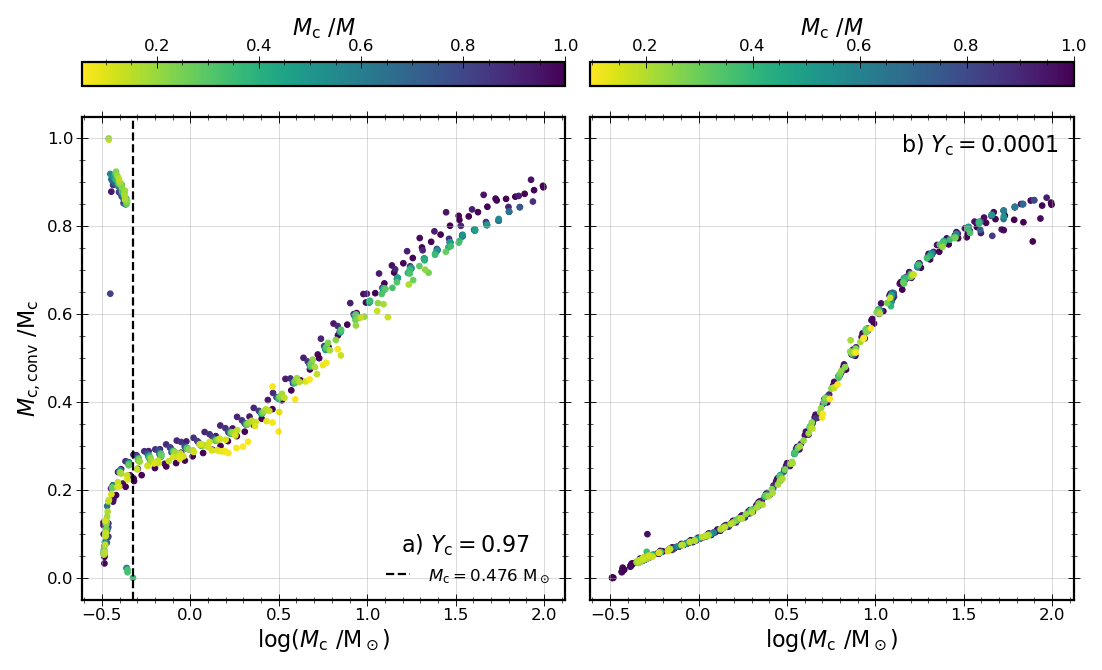

In [61]:
indexes = [-2,2]
Yc_values = df['CENTRAL_HELIUM'].unique()[indexes]
labels = ['a','b']
# print(df_ZAHB.head())
fig,ax=plt.subplots(1,2,figsize=(16,10),sharex=True,sharey=True)
ax[0].axvline(np.log10(0.476),c='black',ls='--',label='$M_\mathrm{c}=0.476~\mathrm{M}_\odot$')

for i,Yc in enumerate(Yc_values):
    df_ZAHB = df[df['CENTRAL_HELIUM']==Yc]
    sc = ax[i].scatter(np.log10(df_ZAHB['HELIUM_CORE_MASS_FRACTION']*df_ZAHB['MASS']),df_ZAHB['CONVECTIVE_CORE_MASS_FRACTION']/df_ZAHB['HELIUM_CORE_MASS_FRACTION'],c=df_ZAHB['HELIUM_CORE_MASS_FRACTION'],cmap=cmap.reversed())
    cbar = plt.colorbar(sc,ax=ax[i],location='top',label='$M_\mathrm{c}~/M$')
    ax[i].legend(title=f'{labels[i]}) '+'$Y_\mathrm{c}$'+f'$ = {Yc}$',frameon=False)


ax[0].set(ylabel='$M_\mathrm{c,conv}~/\mathrm{M}_\mathrm{c}$',xlabel='$\log(M_\mathrm{c}~/\mathrm{M}_\odot)$')
ax[1].set(xlabel='$\log(M_\mathrm{c}~/\mathrm{M}_\odot)$')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_conv_core.jpeg',dpi=200)
plt.show()

No handles with labels found to put in legend.


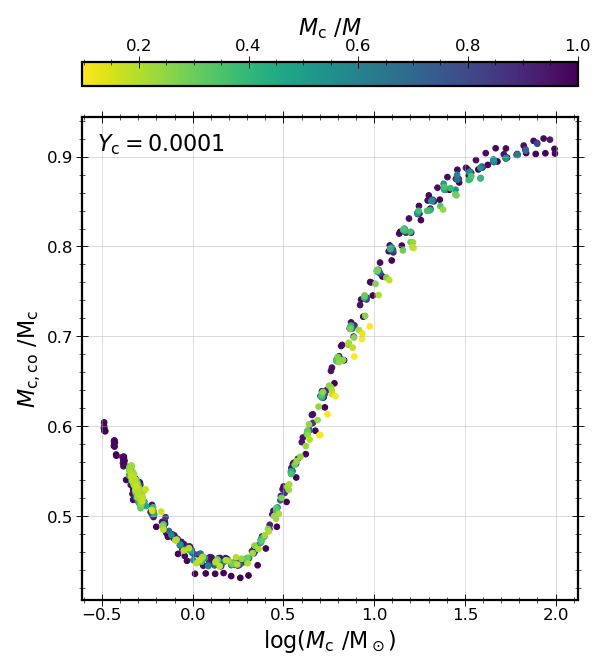

In [62]:
Yc = df['CENTRAL_HELIUM'].unique()[2]
df_TACHeB = df[df['CENTRAL_HELIUM']==Yc]
fig,ax=plt.subplots(figsize=(8,10))
sc = ax.scatter(np.log10(df_ZAHB['HELIUM_CORE_MASS_FRACTION']*df_ZAHB['MASS']),df_ZAHB['CARBON_CORE_MASS_FRACTION']/df_ZAHB['HELIUM_CORE_MASS_FRACTION'],c=df_ZAHB['HELIUM_CORE_MASS_FRACTION'],cmap=cmap.reversed())
ax.set(ylabel='$M_\mathrm{c,co}~/\mathrm{M}_\mathrm{c}$',xlabel='$\log(M_\mathrm{c}~/\mathrm{M}_\odot)$')
ax.legend(title='$Y_\mathrm{c}$'+f'$ = {Yc}$',frameon=False)
cbar = plt.colorbar(sc,ax=ax,location='top',label='$M_\mathrm{c}~/M$')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_co_core.jpeg',dpi=200)
plt.show()

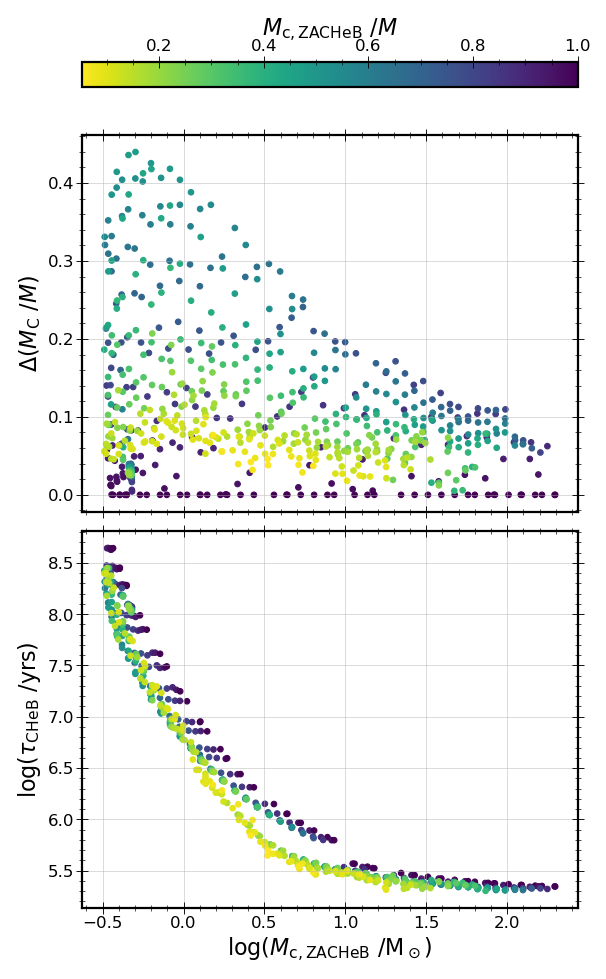

In [126]:
def core_mass_growth(x):
    ZACHeB = x[x['CENTRAL_HELIUM']==x['CENTRAL_HELIUM'].max()]
    TACHeB = x[x['CENTRAL_HELIUM']==x['CENTRAL_HELIUM'].min()]
    delta = TACHeB['HELIUM_CORE_MASS_FRACTION'].values-ZACHeB['HELIUM_CORE_MASS_FRACTION'].values
    return delta[0]

def initial_core_mass(x):
    ZACHeB = x[x['CENTRAL_HELIUM']==x['CENTRAL_HELIUM'].max()]
    return (ZACHeB['HELIUM_CORE_MASS_FRACTION']*ZACHeB['MASS']).values[0]

def cheb_lifetime(x):
    ZACHeB = x[x['CENTRAL_HELIUM']==x['CENTRAL_HELIUM'].max()]
    TACHeB = x[x['CENTRAL_HELIUM']==x['CENTRAL_HELIUM'].min()]
    delta = TACHeB['AGE'].values-ZACHeB['AGE'].values
    return delta[0]

df_core_mass_growth = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x:core_mass_growth(x))
df_initial_core_mass = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x:initial_core_mass(x))
df_initial_core_mass_fraction = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS_FRACTION'].min()
df_lifetime = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x:cheb_lifetime(x))

fig,ax=plt.subplots(2,1,figsize=(8,16),sharex=True)
sc = ax[0].scatter(np.log10(df_initial_core_mass),df_core_mass_growth.values,c=df_initial_core_mass_fraction.values,cmap=cmap.reversed())
sc = ax[1].scatter(np.log10(df_initial_core_mass),np.log10(df_lifetime.values),c=df_initial_core_mass_fraction.values,cmap=cmap.reversed())
ax[0].set(ylabel='$\Delta(M_\mathrm{C}~/M)$')
ax[1].set(xlabel='$\log(M_\mathrm{c,ZACHeB}~/\mathrm{M}_\odot)$',ylabel=r'$\log(\tau_\mathrm{CHeB}~/\mathrm{yrs})$')
cbar = plt.colorbar(sc,ax=ax,location='top',label='$M_\mathrm{c,ZACHeB}~/M$')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_core_growth.jpeg',dpi=200)
plt.show()

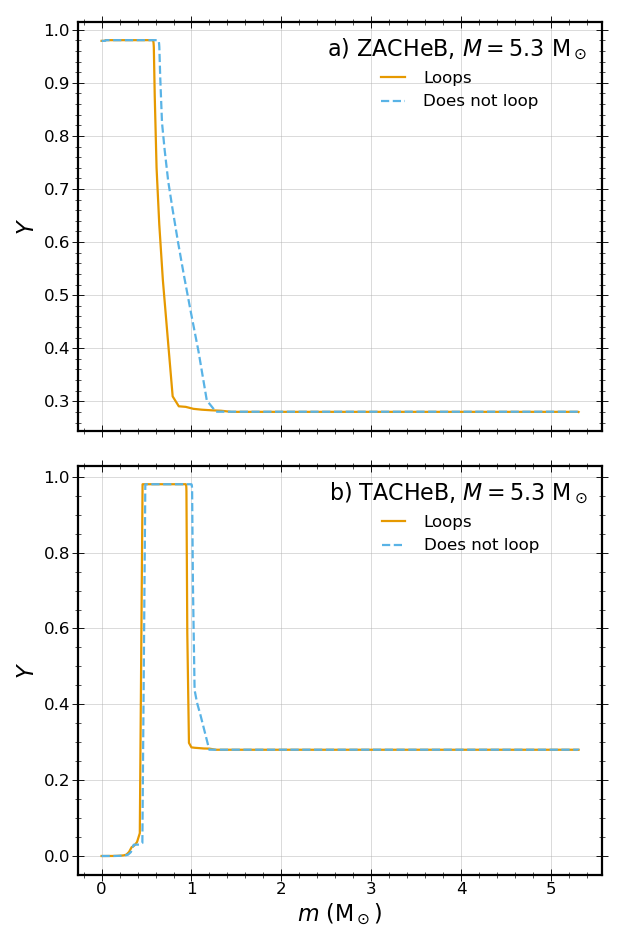

In [123]:
def get_he_profile(df,M,Yc,Mi):

    blue_loop = df[(df['MASS']==M)&(df['CENTRAL_HELIUM']==Yc)&(df['INITIAL_MASS']==Mi)][['CHEBYSHEV_HELIUM_MASS_FRACTION','CHEBYSHEV_MASS']]
    m = [float(i) for i in blue_loop['CHEBYSHEV_MASS'].values[0][1:-1].split()]
    Y = [float(i) for i in blue_loop['CHEBYSHEV_HELIUM_MASS_FRACTION'].values[0][1:-1].split()]

    return m, Y


fig,ax=plt.subplots(2,1,figsize=(8,12),sharex=True)

# old data table
table_name = "tracks_Z%7.2e_%s_old.csv" %(float(metallicity),evol_phase)
table_filepath = os.path.join(f'/Users/natalierees/MINT_grids_23051/Z{metallicity}/{evol_phase}',table_name)
df = pd.read_csv(table_filepath,index_col=[0])

m,Y = get_he_profile(df,M=5.3,Yc=df['CENTRAL_HELIUM'].max(),Mi=3.29) 
ax[0].plot(m,Y,label='Loops')
m,Y = get_he_profile(df,M=5.3,Yc=df['CENTRAL_HELIUM'].max(),Mi=4.38) 
ax[0].plot(m,Y,label='Does not loop')
m,Y = get_he_profile(df,M=5.3,Yc=df['CENTRAL_HELIUM'].min(),Mi=3.29) 
ax[1].plot(m,Y,label='Loops')
m,Y = get_he_profile(df,M=5.3,Yc=df['CENTRAL_HELIUM'].min(),Mi=4.38) 
ax[1].plot(m,Y,label="Does not loop")

# # new data table
# m,Y = get_he_profile(df,M=12.5,Yc=df['CENTRAL_HELIUM'].max(),Mi=12.5) 
# ax[0].plot(m,Y,label='Loops')
# m,Y = get_he_profile(df,M=14.2,Yc=df['CENTRAL_HELIUM'].max(),Mi=14.2) 
# ax[0].plot(m,Y,label='Does not loop')
# m,Y = get_he_profile(df,M=12.5,Yc=df['CENTRAL_HELIUM'].unique()[10],Mi=12.5) 
# ax[1].plot(m,Y,label='Loops')
# m,Y = get_he_profile(df,M=14.2,Yc=df['CENTRAL_HELIUM'].unique()[10],Mi=14.2) 
# ax[1].plot(m,Y,label="Does not loop")

# ax[0].set_xlim(0,4)
ax[0].set(ylabel='$Y$')
ax[1].set(xlabel='$m~(\mathrm{M}_\odot)$',ylabel='$Y$')
ax[0].legend(title='a) ZACHeB, $M=5.3~\mathrm{M}_\odot$',frameon=False)
ax[1].legend(title='b) TACHeB, $M=5.3~\mathrm{M}_\odot$',frameon=False)

fig.tight_layout()
# plt.savefig(f'plots/Z{metallicity}_{evol_phase}_blue_loop_he_profile_comp.jpeg',dpi=200)
plt.show()

